In [447]:
import torch
import torch.nn.functional as F
import pickle 
import numpy as np
import os
import math
import matplotlib.pyplot as plt

In [435]:
def get_adam_grad(top_dir, seed, step, env):
    files = os.listdir(top_dir)
    env_files = [x for x in files if env in x]
    
    beta1 = 0.9
    beta2 = 0.999
    
    # Gradients
    ksl_file_grads = [x for x in env_files if np.all(
        ['optim-ksl' in x, f'-{step}.data' in x, f'-{seed}-' in x, 'sep' in x, 'grads' in x]
    )]
    
    rl_file_grads = [x for x in env_files if np.all(
        ['optim-rl' in x, f'-{step}.data' in x, f'-{seed}-' in x, 'sep' in x, 'grads' in x]
    )]
    
    # Accumulated stats
    ksl_file_m = [x for x in env_files if np.all(
        ['optim-ksl' in x, f'-{step}.data' in x, f'-{seed}-' in x, 'ksl_m' in x]
    )]
    
    ksl_file_v = [x for x in env_files if np.all(
        ['optim-ksl' in x, f'-{step}.data' in x, f'-{seed}-' in x, 'ksl_v' in x]
    )]
    
    rl_file_m = [x for x in env_files if np.all(
        ['optim-rl' in x, f'-{step}.data' in x, f'-{seed}-' in x, 'rl_m' in x]
    )]
    
    rl_file_v = [x for x in env_files if np.all(
        ['optim-rl' in x, f'-{step}.data' in x, f'-{seed}-' in x, 'rl_v' in x]
    )]
    
    # Gradients
    with open(top_dir + ksl_file_m[0], 'rb') as f:
        ksl_grads = pickle.load(f)
        
    with open(top_dir + ksl_file_m[0], 'rb') as f:
        rl_grads = pickle.load(f)
    
    # Accumulated statistics
    with open(top_dir + ksl_file_m[0], 'rb') as f:
        ksl_m = pickle.load(f)
        
    with open(top_dir + ksl_file_v[0], 'rb') as f:
        ksl_v = pickle.load(f)
        
    with open(top_dir + rl_file_m[0], 'rb') as f:
        rl_m = pickle.load(f)
        
    with open(top_dir + rl_file_v[0], 'rb') as f:
        rl_v = pickle.load(f)
        
    # Correcting bias and altering the projection with the sampled gradients
    rl_corrected = []
    for i, param_grad in enumerate(rl_grads[:10]):
        bias_correction1 = 1 - beta1 ** step
        bias_correction2 = 1 - beta2 ** step
        
        rl_m[i].mul_(beta1).add_(param_grad, alpha=1 - beta1)
        rl_v[i].mul_(beta2).addcmul_(param_grad, param_grad.conj(), value=1 - beta2)
        
        denom = (rl_v[i].sqrt() / math.sqrt(bias_correction2)).add(1e-6)
        num = rl_m[i] / bias_correction1
        rl_corrected.append(num / denom)
        
    ksl_corrected = []
    for i, param_grad in enumerate(ksl_grads[:10]):
        bias_correction1 = 1 - beta1 ** step
        bias_correction2 = 1 - beta2 ** step
        
        ksl_m[i].mul_(beta1).add_(param_grad, alpha=1 - beta1)
        ksl_v[i].mul_(beta2).addcmul_(param_grad, param_grad.conj(), value=1 - beta2)
        
        denom = (ksl_v[i].sqrt() / math.sqrt(bias_correction2)).add(1e-6)
        num = ksl_m[i] / bias_correction1
        ksl_corrected.append(num / denom)
        
    angle_measure = torch.nn.CosineSimilarity(dim=0)
    
    angles = []
    
    for i in range(10):
        ksl_update = ksl_corrected[i]
        rl_update = rl_corrected[i]
        angles.append(angle_measure(ksl_update.view(-1), rl_update.view(-1)))
        
    return ksl_m, ksl_v, rl_m, rl_v, angles

In [443]:
top_dir = '<ENTER/LOCATION/HERE>'

all_seeds = []

for seed in [1476, 11178, 142278]:
    steps = [(x + 1) * 5000 for x in range(10)]

    seed_angles = []

    for step in steps:
        _, _, _, _, angles = get_adam_grad(
            top_dir=top_dir, seed=seed, step=step, env='walker'
        )
        seed_angles.append(torch.tensor(angles).mean().item())
    
    all_seeds.append(seed_angles)

1476
11178
142278


(-1.0, 1.0)

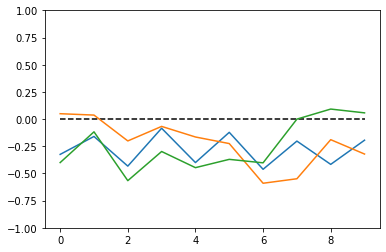

In [445]:
for run in all_seeds:
    plt.plot(run)

plt.hlines(0, 0, 9, colors='black', linestyles='dashed')
plt.ylim(-1, 1)

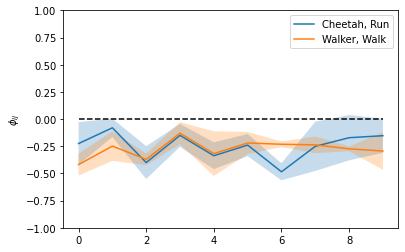

In [446]:
l = 10
plt.plot(np.mean(np.array(all_seeds), axis=0))
plt.fill_between(range(l),
                 np.mean(np.array(all_seeds), axis=0) + np.std(np.array(all_seeds), axis=0),
                 np.mean(np.array(all_seeds), axis=0) - np.std(np.array(all_seeds), axis=0),
                 alpha=0.25)


plt.plot(np.mean(np.array(all_seeds2), axis=0))
plt.fill_between(range(10),
                 np.mean(np.array(all_seeds2), axis=0) + np.std(np.array(all_seeds2), axis=0),
                 np.mean(np.array(all_seeds2), axis=0) - np.std(np.array(all_seeds2), axis=0),
                 alpha=0.25)

plt.hlines(0, 0, 9, colors='black', linestyles='dashed')
plt.ylabel(r'$\phi_{ij}$')
plt.ylim(-1, 1)
plt.legend(['Cheetah, Run', 'Walker, Walk'])